# Imports

### Libraries

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as dates_
import seaborn as sns
from pyowm.owm import OWM
from pyowm.utils import timestamps, formatting
from datetime import datetime, timedelta, timezone, date

### Data

##### Picking the day

In [107]:
now = datetime.now().day
day = 4
month = 12
year = 2021
offset = now - day

##### Accelerometer Data

In [92]:
dir_ = "data/24H/user_1/Actigraph.csv" # Create path
df_accel = pd.read_csv(dir_) # Load data

# Extract stress data
dir_ = "data/24H/user_1/questionnaire.csv" # Create path
df_stress = pd.read_csv(dir_) # Load data

# Extract saliva data
dir_ = "data/24H/user_1/saliva.csv" # Create path
df_saliva = pd.read_csv(dir_) # Load data

# Append columns to initial dataframe
stress_col = (np.ones(len(df_accel)) * df_stress['Daily_stress'][0]).astype(int)
cortisol_before_sleep_col = (np.ones(len(df_accel)) * df_saliva['Cortisol NORM'][0])

df_accel['stress_level'] = stress_col
df_accel['cortisol_before_sleep'] = cortisol_before_sleep_col


# Change data type
df_accel['time'] = df_accel['time'].apply(lambda t : datetime.strptime(t, '%H:%M:%S'))

# Drop the first column, which is useless
cols_to_drop = ['HR', 'Steps', 'Unnamed: 0', 'Axis1', 'Axis2', 'Axis3', 'Inclinometer Off', 'Inclinometer Standing', 'Inclinometer Sitting', 'Inclinometer Lying', 'day']
df_accel = df_accel.drop(cols_to_drop, axis=1)

# Downsampledata
#df_accel = df_accel[25:]
df_accel = df_accel.iloc[::60, :]
df_accel = df_accel.reset_index()
# Filter data
df_accel['Vector Magnitude'] = df_accel['Vector Magnitude'].rolling(window=5).mean(std=0.5)

In [3]:
df_accel.head(30)
#type(df_accel['time'].iloc[0])

,index,Vector Magnitude,time,stress_level,cortisol_before_sleep
0,0,NaN,1900-01-01 10:10:22,23,0.034137
1,60,NaN,1900-01-01 10:12:44,23,0.034137
2,120,NaN,1900-01-01 10:13:56,23,0.034137
3,180,NaN,1900-01-01 10:15:15,23,0.034137
4,240,85.536,1900-01-01 10:16:27,23,0.034137
5,300,103.328,1900-01-01 10:17:39,23,0.034137
6,360,67.418,1900-01-01 10:18:51,23,0.034137
7,420,64.018,1900-01-01 10:20:09,23,0.034137
8,480,69.890,1900-01-01 10:21:21,23,0.034137
9,540,51.454,1900-01-01 10:22:33,23,0.034137


##### Heart Beat Data

In [4]:
# Find all json files
samsung_base_dir = os.path.join('data', 'Samsung Data', '28.11.2021')

json_file_names = []
for file in os.listdir(os.path.join(samsung_base_dir, 'jsons', 'com.samsung.health.heart_rate')):
    if file != '.ipynb_checkpoints':
        json_file_names.append(file)

df_json_readings = []
for i in range(len(json_file_names)):
    file_name = json_file_names[i]
    df = pd.read_json(os.path.join(samsung_base_dir,'jsons', 'com.samsung.health.heart_rate', file_name))
    df_json_readings.append(df.copy())

df_heart_rate_json = pd.concat(df_json_readings, axis=0, ignore_index=True)
df_heart_rate_json = df_heart_rate_json.sort_values(by=['start_time'], ascending=True, ignore_index=True)


In [5]:
df_heart_rate_json.head()

,heart_rate,heart_rate_max,heart_rate_min,start_time,end_time
0,80,82,79,2021-11-28 12:40:00,2021-11-28 12:40:59
1,83,87,78,2021-11-28 12:41:00,2021-11-28 12:41:59
2,82,85,80,2021-11-28 12:42:00,2021-11-28 12:42:59
3,83,86,80,2021-11-28 12:43:00,2021-11-28 12:43:59
4,80,82,77,2021-11-28 12:44:00,2021-11-28 12:44:59


##### Calendar Data

In [98]:
# Load CSV file
cal_base_dir = os.path.join('data', 'Calendar Data')
df_calendar = pd.read_csv(os.path.join('data', 'Calendar Data', '22.11.2021.csv'), sep='\t')

# Rename columns with simpler names
df_calendar = df_calendar.rename(columns={'Given planned earliest start' : 'start_time', 'Given planned earliest end' : 'end_time'})
df_calendar = df_calendar.drop(['Notes', 'Assigned Resources', 'Additional Title'], axis=1)

# Convert date columns into date format
df_calendar['start_time'] = pd.to_datetime(df_calendar['start_time'], dayfirst=True)
df_calendar['end_time'] = pd.to_datetime(df_calendar['end_time'], dayfirst=True)

# Sort Dataframe by date
df_calendar = df_calendar.sort_values(by=['start_time'], ascending=True, ignore_index=True)

In [99]:
df_calendar.head()

,Title,start_time,end_time
0,Physio,2020-07-01 15:30:00,2020-07-01 16:30:00
1,Rdv edm pour les sats,2020-07-01 18:00:00,2020-07-01 19:00:00
2,Rdv Jessie sortie,2020-07-01 21:00:00,2020-07-01 22:00:00
3,Physio,2020-07-06 13:30:00,2020-07-06 14:30:00
4,Anni Clem Co,2020-07-07 12:00:00,2020-07-07 13:00:00


##### Weather Data
We can go back up to 5 days ago, but unfortunately not more than that.

In [108]:
APIKEY = '12c406b33039d61c116a70eefb3526bb' #your API Key here as string
OpenWMap = OWM(APIKEY) # Use API key to get data
mgr = OpenWMap.weather_manager()
lausanne_lat = 46.5196535
lausanne_lon = 6.6322734

# Query current data
observation_cur = mgr.weather_at_place('Lausanne') # give where you need to see the weather
weather_cur = observation_cur.weather

# Query yesterday data
yesterday_epoch = formatting.to_UNIXtime(timestamps.yesterday())
one_call_yesterday = mgr.one_call_history(lat=lausanne_lat, lon=lausanne_lon, dt=yesterday_epoch)
weather_yesterday = one_call_yesterday.forecast_hourly

# Query 4 days ago data
nb_of_days = offset
three_days_ago_epoch = int((datetime.now() - timedelta(days=nb_of_days)).replace(tzinfo=timezone.utc).timestamp())
one_call_four_days_ago = mgr.one_call_history(lat=52.5244, lon=13.4105, dt=three_days_ago_epoch)
weather_four_days_ago = one_call_four_days_ago.forecast_hourly

In [109]:
# Iterate over each hour of the day
for i in range(len(weather_four_days_ago)):
    print(weather_four_days_ago[i].detailed_status)
    print(weather_four_days_ago[i].temperature('celsius'))

light snow
{'temp': 1.19, 'feels_like': -3.85}
light snow
{'temp': 1.45, 'feels_like': -3.73}
light rain
{'temp': 1.54, 'feels_like': -3.18}
light snow
{'temp': 1.57, 'feels_like': -2.91}
broken clouds
{'temp': 1.64, 'feels_like': -2.28}
light intensity drizzle
{'temp': 1.71, 'feels_like': -2.2}
light snow
{'temp': 1.64, 'feels_like': -1.98}
light snow
{'temp': 1.56, 'feels_like': -2.66}
broken clouds
{'temp': 1.55, 'feels_like': -2.09}
broken clouds
{'temp': 1.68, 'feels_like': -2.23}
broken clouds
{'temp': 2.14, 'feels_like': -1.03}
broken clouds
{'temp': 2.21, 'feels_like': -1.86}
broken clouds
{'temp': 2.33, 'feels_like': -1.71}
broken clouds
{'temp': 2.62, 'feels_like': -0.46}
overcast clouds
{'temp': 2.49, 'feels_like': -0.61}
overcast clouds
{'temp': 2.3, 'feels_like': -1.18}
overcast clouds
{'temp': 2.17, 'feels_like': -1.63}
overcast clouds
{'temp': 1.87, 'feels_like': -1.7}
broken clouds
{'temp': 1.76, 'feels_like': -2.67}
broken clouds
{'temp': 1.84, 'feels_like': -2.04}
bro

##### Step Count Data

In [100]:
# Find all json files
samsung_base_dir = os.path.join('data', 'Samsung Data', '04.11.2021')

# Finding step count file
filename = ''
for file in os.listdir(samsung_base_dir):
    if file.startswith('com.samsung.health.step_count'):
        filename = file


# Importing data
cols_names = ["speed", "pkg_name", "count", "sample_position_type", "time_offset", "start_time", "calorie", 
              "deviceuuid", "custom", "end_time", "datauuid", "distance", "create_time", "update_time"]
df_step_count = pd.read_csv(os.path.join(samsung_base_dir, filename), skiprows=1,names=cols_names)

# Cleaning dataset
cols_to_drop = ["pkg_name", "sample_position_type", "time_offset", "deviceuuid", "custom", "datauuid", "create_time", "update_time"]
df_step_count = df_step_count[1:]
df_step_count = df_step_count.drop(cols_to_drop, axis=1)
#df_step_count


In [101]:
df_step_count.head()

,speed,count,start_time,calorie,end_time,distance
1,1.388889,16,28.11.2021 à 13:50:00,0.570000,28.11.2021 à 13:50:59,11.510000
2,1.497405,22,28.11.2021 à 13:51:00,0.730000,28.11.2021 à 13:51:59,17.090000
3,1.277778,17,28.11.2021 à 13:56:00,0.590000,28.11.2021 à 13:56:59,12.440000
4,2.027778,19,28.11.2021 à 14:06:00,0.660000,28.11.2021 à 14:06:59,15.370000
5,1.277778,15,28.11.2021 à 14:11:00,0.520000,28.11.2021 à 14:11:59,11.120000


# Use-case : 4 days ago (24.11.2021)
As we did not have data for the heart rate then, we will use the data we have from today, and pretend it was taken on that day. As this is merely an example, we will look at it during a day, but the analysis can easily be repeated fro a week, or larger period.

##### Filter calendar data to keep only data for a day

In [77]:
# Setup data
df_filtered_dates = df_calendar.copy()
year_to_keep = 2021
month_to_keep = 12
day_to_keep = 3

# Create mask for filtering
mask = (df_filtered_dates['start_time'] >= datetime(year_to_keep, month_to_keep, day_to_keep)) & (df_filtered_dates['start_time'] <= datetime(year_to_keep, month_to_keep, day_to_keep+1))

# Apply mask
df_filtered_dates = df_filtered_dates.loc[mask]

# Create mask for bars in plotting
df_filtered_dates['plot_dummies'] = np.ones(len(df_filtered_dates)).astype(int)*df_heart_rate_json['heart_rate_max'].max()
#df_filtered_dates.at[893,'Title']= "Repas avec Flo à Morges" 

df_filtered_dates['bar_width'] = df_filtered_dates['end_time'] - df_filtered_dates['start_time']
df_filtered_dates['bar_width'] = df_filtered_dates['bar_width'].apply(lambda t : t.seconds//3600 * 0.0415)

In [78]:
df_filtered_dates.head()

,Title,start_time,end_time,plot_dummies,bar_width
902,Portugal,2021-12-03,2021-12-07,119,0.0


##### Update day information for accelerometer

In [94]:
df_accel['time'] = df_accel['time'].apply(lambda t : t.replace(day=day_to_keep, month=month_to_keep, year=year_to_keep))
df_accel = df_accel[60*2:600]
df_accel = df_accel.iloc[:, 1:]
# Create mask for filtering
#mask = (df_accel['time'] >= datetime(year_to_keep, month_to_keep, day_to_keep)) & (df_accel['time'] <= datetime(year_to_keep, month_to_keep, day_to_keep+1))

# Apply mask
#df_accel = df_accel.loc[mask]

In [95]:
df_accel.head()

,time,stress_level,cortisol_before_sleep
240,2021-12-03 15:07:14,23,0.034137
241,2021-12-03 15:08:26,23,0.034137
242,2021-12-03 15:09:38,23,0.034137
243,2021-12-03 15:10:56,23,0.034137
244,2021-12-03 15:12:08,23,0.034137


##### Prepare weather data for plotting

In [110]:
# Weather data
actual_temp = []
feels_like_temp = []
weather = []

for i in range(len(weather_four_days_ago)):
    actual_temp.append(weather_four_days_ago[i].temperature('celsius')['temp'])
    feels_like_temp.append(weather_four_days_ago[i].temperature('celsius')['feels_like'])
    weather.append(weather_four_days_ago[i].detailed_status)

In [111]:
data_range = pd.date_range(start=datetime(year_to_keep, month_to_keep, day_to_keep, 0, 0, 0), periods=24, freq="60 min")

# Create datafram
weather_data = [actual_temp, feels_like_temp, weather]
df_weather = pd.DataFrame(np.vstack(weather_data))
df_weather = df_weather.T
df_weather = df_weather.rename(columns={0:'actual_temp', 1:'feels_like_temp', 2: 'weather'})
df_weather['time'] = data_range

df_weather['actual_temp'] = df_weather['actual_temp'].astype(float)
df_weather['feels_like_temp'] = df_weather['feels_like_temp'].astype(float)

In [112]:
df_weather.head(50)

,actual_temp,feels_like_temp,weather,time
0,1.19,-3.85,light snow,2021-12-03 00:00:00
1,1.45,-3.73,light snow,2021-12-03 01:00:00
2,1.54,-3.18,light rain,2021-12-03 02:00:00
3,1.57,-2.91,light snow,2021-12-03 03:00:00
4,1.64,-2.28,broken clouds,2021-12-03 04:00:00
5,1.71,-2.20,light intensity drizzle,2021-12-03 05:00:00
6,1.64,-1.98,light snow,2021-12-03 06:00:00
7,1.56,-2.66,light snow,2021-12-03 07:00:00
8,1.55,-2.09,broken clouds,2021-12-03 08:00:00
9,1.68,-2.23,broken clouds,2021-12-03 09:00:00


##### Change day (cheating on day of heart rate measurement)

In [90]:
offset = date.today().day - day_to_keep - 2
df_heart_rate_json['start_time'] = df_heart_rate_json['start_time'].apply(lambda t : t.replace(day=day_to_keep, month=month_to_keep, year=year_to_keep))
df_heart_rate_json['end_time'] = df_heart_rate_json['end_time'].apply(lambda t : t.replace(day=day_to_keep, month=month_to_keep, year=year_to_keep))


In [91]:
df_heart_rate_json.head()

,heart_rate,heart_rate_max,heart_rate_min,start_time,end_time
0,80,82,79,2021-12-03 12:40:00,2021-12-03 12:40:59
1,83,87,78,2021-12-03 12:41:00,2021-12-03 12:41:59
2,82,85,80,2021-12-03 12:42:00,2021-12-03 12:42:59
3,83,86,80,2021-12-03 12:43:00,2021-12-03 12:43:59
4,80,82,77,2021-12-03 12:44:00,2021-12-03 12:44:59


##### Prepare step count data

# Plotting all together

KeyError: 'Vector Magnitude'

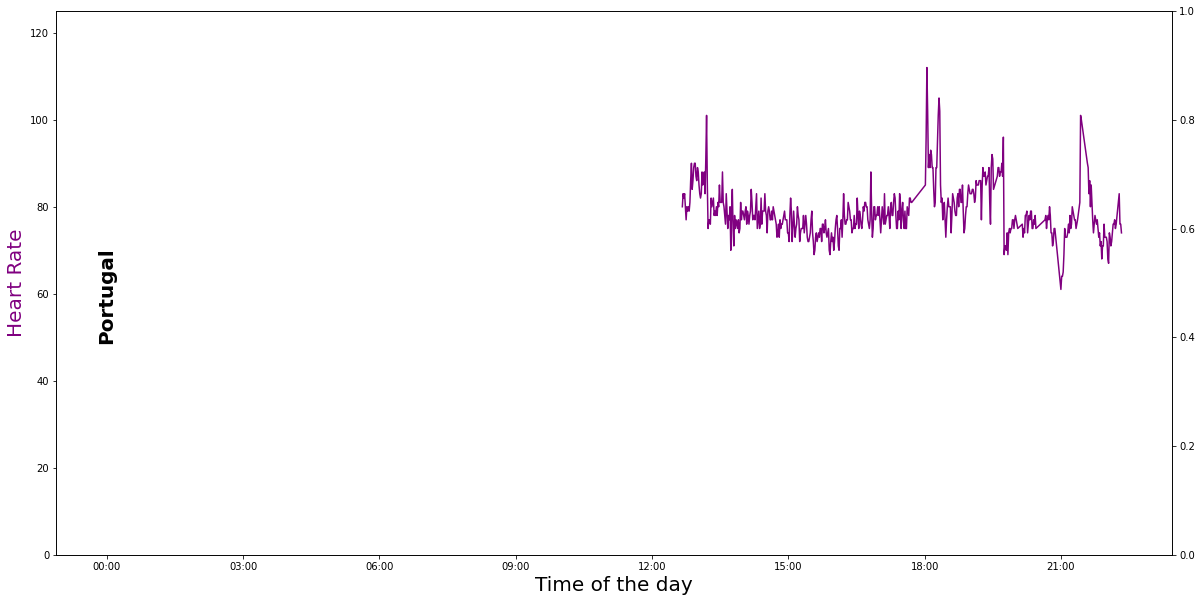

In [113]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20, 10))

# Plot Hear rate data
hr = ax.plot(df_heart_rate_json['start_time'],
        df_heart_rate_json['heart_rate'],
        color='purple', label='Heart Rate')

#accel = ax.plot(df_accel['time'], df_accel['Vector Magnitude'])


# Set bar plots style for events
cal = ax.bar(df_filtered_dates['start_time'],
        df_filtered_dates['plot_dummies'],
        color='green', width=df_filtered_dates['bar_width'], alpha=0.2, label='Calendar events', align='edge')
ax.bar_label(cal, labels=df_filtered_dates['Title'], label_type='center', rotation=90, weight='bold', fontsize=20)

# Format dates as hours:minutes
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)


# Set title and labels for axes
ax.set_xlabel("Time of the day", fontsize=20)

ax.set_ylabel("Heart Rate", color="purple", fontsize=20)

# Create format for plotting temperature
#ax2=ax.twinx()

#Remove the night for purposes of plotting
df_weather_loc = df_weather.copy()
df_weather_loc = df_weather_loc.drop(range(13))

#ax2.plot(df_weather_loc['time'], df_weather_loc['actual_temp'], color='red', label='Actual Temperature')
#ax2.set_ylabel("Temperature (celsisus)")

# Ading legends
#ax.legend(bbox_to_anchor=(0.985, 1), prop={"size":20})


ax2=ax.twinx()
ax2.plot(df_accel['time'], df_accel['Vector Magnitude'], label="Accelerometer")

#ax2.legend("Accelerometer", prop={"size":20})
#ax.legend("Hear rate", prop={"size":20})
ax.set_ylabel("Heart Rate", color="purple", fontsize=20)
ax2.set_ylabel("Accelerometer", color="blue", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=8)

# Ading legends
# bbox_to_anchor=(0.985, 1), 
ax.legend(prop={"size":20})
# bbox_to_anchor=(0.999, 0.93),
ax2.legend(bbox_to_anchor=(0.9835, 0.88), prop={"size":20})

#sns.set()
plt.savefig("images/cal_events_correlation.png", transparent=True)

In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20, 10))

#Remove the night for purposes of plotting
df_weather_loc = df_weather.copy()
df_weather_loc = df_weather_loc.drop(range(13))

# Set bar plots style for events
weather = ax.bar(df_weather_loc['time'],
        df_weather_loc['actual_temp'],
        color='orange', width=0.03, alpha=0.2, label='Weather status')
ax.bar_label(weather, labels=df_weather_loc['weather'], label_type='center', rotation=90, weight='bold', fontsize=20)

# Format dates as hours:minutes
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)


# Set title and labels for axes
ax.set_xlabel("Time of the day", fontsize=20)
ax.set_ylabel("Temperature (celsius)", color="orange", fontsize=20)
# Create format for plotting temperature
ax2=ax.twinx()


# Plot Hear rate data
ax2.plot(df_heart_rate_json['start_time'],
        df_heart_rate_json['heart_rate'],
        color='purple', label='Heart Rate')
#ax2.plot(df_weather_loc['time'], df_weather_loc['actual_temp'], color='red', label='Actual Temperature')
ax2.set_ylabel("Heart rate", color="purple", fontsize=20)

# Ading legends
# bbox_to_anchor=(0.985, 1), 
ax.legend(prop={"size":20})
# bbox_to_anchor=(0.999, 0.93),
ax2.legend(bbox_to_anchor=(0.999, 0.93), prop={"size":20})

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=8)

# Display plot
plt.savefig("images/weather_events_correlation.png", transparent=True)
plt.show()
